## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [7]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy import io, signal
from matplotlib import pyplot as plt
from matplotlib import mlab

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls  = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    data
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    # are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]
    
    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def LowpassFilter(signal, passband):
    b, a = sp.signal.butter(3, passband, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
   
    # Compute aggregate error metric
    errs  = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl): 
    """ Calculates mean absolute errors and confidence values
    
    Args: 
        data_fl: (str) filepath to a troika .mat file.
        ref_f1: (str) filepath to a troika .mat file which contains reference heart beat estimates.
        
    Returns:
        error_array: Array of absolute errors
        conf_array: Array of confidence values for each error value.
    """
        
    # Load data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ground_truth = sp.io.loadmat(ref_fl)['BPM0']
    ground_truth = ground_truth.reshape(-1)
    
    # Band pass ppg and acc signals 
    bandpassed_ppg = LowpassFilter(ppg, (min_freq, max_freq))
    
    # Splits of 8-second windows with 6-second overlaps since ground truth slides every 2 seconds
    spec_ppg, freqs_ppg, _  = mlab.specgram(bandpassed_ppg, Fs=fs, NFFT=fs*8, noverlap = 6*fs, pad_to=12*fs)
    # plt.xlabel('Time')
    # plt.ylabel('Frequency')
    # plt.title("Bandpass filtered PPG signal")
    accx = LowpassFilter(accx, (min_freq, max_freq))
    accy = LowpassFilter(accy, (min_freq, max_freq))
    accz = LowpassFilter(accz, (min_freq, max_freq))

    bandpassed_acc_mag = np.sqrt(np.sum(np.square(np.vstack((accx, accy, accz))), axis=0))
    spec_acc, freqs_acc, _    = mlab.specgram(bandpassed_acc_mag, Fs=fs, NFFT=fs*8, noverlap = 6*fs, pad_to=12*fs)
    spec_accx, freqs_accx, _  = mlab.specgram(accx, Fs=fs, NFFT=fs*8, noverlap = 6*fs, pad_to=12*fs)
    spec_accy, freqs_accy, _  = mlab.specgram(accy, Fs=fs, NFFT=fs*8, noverlap = 6*fs, pad_to=12*fs)
    spec_accz, freqs_accz, _  = mlab.specgram(accz, Fs=fs, NFFT=fs*8, noverlap = 6*fs, pad_to=12*fs)

    # Pass through a frequency band that makes physiological sense.
    # This reduces the number of frequencies
    freqs_ppg  = freqs_ppg [(freqs_ppg >= min_freq) & (freqs_ppg <= max_freq)]
    freqs_acc  = freqs_acc [(freqs_acc >= min_freq) & (freqs_acc <= max_freq)]
    freqs_accx = freqs_accx [(freqs_accx >= min_freq) & (freqs_accx <= max_freq)]
    freqs_accy = freqs_accy [(freqs_accy >= min_freq) & (freqs_accy <= max_freq)]
    freqs_accz = freqs_accz [(freqs_accz >= min_freq) & (freqs_accz <= max_freq)]

    # Corresponding to applying the band pass on the frequencies, we have to "sanitize" the spectrum array 
    # as well. So the number of rows (spec_ppg.shape[0]) will become shorter. The number of columns will remain the
    # same, corresponding to the number of time blocks
    spec_ppg  = spec_ppg [(freqs_ppg >= min_freq) & (freqs_ppg <= max_freq)]
    spec_acc  = spec_acc [(freqs_acc >= min_freq) & (freqs_acc <= max_freq)]
    spec_accx = spec_accx [(freqs_accx >= min_freq) & (freqs_accx <= max_freq)]
    spec_accy = spec_accy [(freqs_accy >= min_freq) & (freqs_accy <= max_freq)]
    spec_accz = spec_accz [(freqs_accz >= min_freq) & (freqs_accz <= max_freq)]
    
    # spec_ppg is a 2D array. The COLUMNS correspond to each time block. The rows within each column correspond to 
    # frequency values
    num_time_blocks = spec_ppg.shape[1]
    num_frequencies = freqs_ppg.shape[0]
    #print ("num=", num_time_blocks)
    
    # Sort in descending order, so -1*spec
    # Each row corresponds to one time block
    sorted_spectrum_ppg  = (-spec_ppg).argsort(axis=0)
    sorted_spectrum_acc  = (-spec_acc).argsort(axis=0)
    sorted_spectrum_accx = (-spec_accx).argsort(axis=0)
    sorted_spectrum_accy = (-spec_accy).argsort(axis=0)
    sorted_spectrum_accz = (-spec_accz).argsort(axis=0)

    predicted_freqs = []
    for i in range(num_time_blocks):
        flag = 0
        
        if (freqs_ppg[sorted_spectrum_ppg[0][i]]   == freqs_accx[sorted_spectrum_accx[0][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accy[sorted_spectrum_accy[0][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accz[sorted_spectrum_accz[0][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_acc[sorted_spectrum_acc[0][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accx[sorted_spectrum_accx[1][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accy[sorted_spectrum_accy[1][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accz[sorted_spectrum_accz[1][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_acc[sorted_spectrum_acc[1][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accx[sorted_spectrum_accx[2][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accy[sorted_spectrum_accy[2][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_accz[sorted_spectrum_accz[2][i]]):
            flag = 1
        elif (freqs_ppg[sorted_spectrum_ppg[0][i]] == freqs_acc[sorted_spectrum_acc[2][i]]):
            flag = 1
        else:
            #print ("Dominant Freq Chosen")
            predicted_freqs.append (freqs_ppg[sorted_spectrum_ppg[0][i]])
        
        if (flag):         
             flag = 0
             if (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accx[sorted_spectrum_accx[0][i]]):
                 flag = 1
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accy[sorted_spectrum_accy[0][i]]):
                 flag = 1
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accz[sorted_spectrum_accz[0][i]]):
                 flag = 1     
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accx[sorted_spectrum_accx[1][i]]):
                 flag = 1
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accy[sorted_spectrum_accy[1][i]]):
                 flag = 1
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accz[sorted_spectrum_accz[1][i]]):
                 flag = 1   
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accx[sorted_spectrum_accx[2][i]]):
                 flag = 1
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accy[sorted_spectrum_accy[2][i]]):
                 flag = 1
             elif (freqs_ppg[sorted_spectrum_ppg[1][i]] == freqs_accz[sorted_spectrum_accz[2][i]]):
                 flag = 1   
                
             if (flag):
                 #print ("Second Max Freq Chosen")
                predicted_freqs.append (freqs_ppg[sorted_spectrum_ppg[2][i]]) 
             else:
                 #print ("Third Max Freq Chosen")
                predicted_freqs.append (freqs_ppg[sorted_spectrum_ppg[1][i]])   

    predicted_freqs_array = np.array(predicted_freqs)*60
    #print ("Lengths=", len(predicted_freqs_array), len(ground_truth))
    #print ("Pred BPM =", predicted_freqs_array, "Ground Truth =", ground_truth)
    plt.clf()
    plt.figure(0)
    plt.title('Predictions vs Ground Truth')
    plt.plot (predicted_freqs_array)
    plt.plot (ground_truth)
    error = np.abs(predicted_freqs_array - ground_truth)
    
    confidence_list = []
    i = 0
    for i in range(len(predicted_freqs)):
        pred = predicted_freqs[i]
        harmonic_f = pred * 2
    
        freqs = np.fft.rfftfreq(len(ppg)*2, 1/fs)
        fft_mag = np.abs(np.fft.rfft(ppg, len(ppg)*2))

        window_slice = 15/60
        fwindow_size = (freqs > pred - window_slice) & (freqs < pred + window_slice)
        hwindow_size = (freqs > harmonic_f - window_slice) & (freqs < harmonic_f + window_slice)
        signal = np.sum(fft_mag[(fwindow_size) | (hwindow_size)])
        noise = np.sum(fft_mag[~ ((fwindow_size) | (hwindow_size))])
        # signal = np.sum(fft_mag[(fwindow_size)])
        # noise = np.sum(fft_mag[~ (fwindow_size)])

        snr_ratio = signal/noise 
        confidence_list.append(snr_ratio)

    confidence = np.array(confidence_list)

    return error, confidence


Starting..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:144: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 751 but corresponding boolean dimension is 40
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:145: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 751 but corresponding boolean dimension is 40
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:146: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 751 but corresponding boolean dimension is 40
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:147: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 751 but corresponding boolean dimension is 40
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:148: VisibleDeprecationWarning: boolean index did not match indexed array along dimensi

Error = 48.6712792256


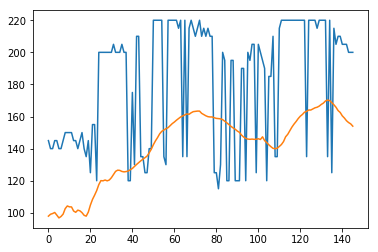

In [8]:
fs = 125 # The data set documentation says all signals were sampled at 125 HZ
min_freq= 0.67
max_freq= 4.0
print ("Starting..")
error = Evaluate()
print ("Error =", error)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

In [8]:
"""
This project seeks to determine the heart rate from PPG signals captured from a wearable and corroborate/tune 
results with the help of data elicited from an accelerometer. 

- All signals are tuned using a bandpass filter to cancel frequencies outside of 0.67 HZ40 BPM) and 3.3 HZ (200 BPM). 
  Please see observation 6/ below.
- The algorithm then slices each PPG, ACCX, ACCY and ACCZ datasets into sliding chunks of 8-seconds using specgram()
- It then uses the frequency domain data returned by specgram()
- All frequencies outside of the physiologically relevant band are weeded out.
- The output is sorted on the spectral magnitude of the data and the top 3 frequencies are considered
- Peaks of the Accelerometer Magnitude (L2 Norm) are also calculated

If the dominant PPG peak does not coincide with the first, second or third peaks of ACCX, ACCY, ACCZ and ACC Magnitude, 
that is chosen as the predicted heart rate. Else, we move to the second dominant PPG peak and see if it coincides 
with the top 3 peaks of the accelerometer component signals. If not, that is chosen as the predicted heart rate. 
Else, the third dominant PPG peak is chosen as the predicted heart rate.

This is compared with the ground truth and the error vector is calculated.

Next, we calculate a degree of confidence and the error vectors of the samples that have the bottom 10% SNR
are weeded out.

The mean of the residual error vector is calculated as the final result.

Experiments to improve accuracy and ensuing observations:
    1/ I am checking variance of the PPG peaks with the accelerometer component signal peaks (accx, accy, accz) 
       as well as  with the accelerometer magnitude (L2Norm) peaks. However the accelerometer magnitude peaks 
       do not seem to have any additional bearing on improving the accuracy of results.
    2/ Without the help of the accelerometer, the error more than doubles. As more peaks from accelerometer data is
       leveraged, the error progressively reduces. For example, if only the first peak is considered from accx/accy/accz,
       the manifested error is about 20% more than if the first and second peaks are considered.
    3/ 90th percentile calculation with the fundamental frequency alone (without harmonics) is yielding same results as
       expanding the spectral band to include both the fundamental frequency band and the first harmonic. In other words
       considering the harmonic is not making a difference to the final result
    4/ If allowed to increase the tolerated confidence level, the error is showing a downward trend. For example,
       if only samples greater than an 80% confidence level are chosen (instead of 90%), the error rate comes down
       by about 5%. However, since the question asks for only the bottom 10% to be weeded out, I have let it at that
       level.
    5/ I have tried various values of width of the band around the peak to calculate the SNR. I have currently set it to
       the width to 0.25 HZ
    6/ I have also tried tuning min_freq and max_freq. A reduction of max_freq to 200 BPM or 3.3 HZ (rather than 240 BPM) 
       brings significant improvement to the accuracy. I do understand the trade-offs, but I have let the max at 3.3 HZ.
       I assume that if a patient's heart beat is detected close to 200 BPM, the patient is likely to be red-flagged 
       for more tests.
"""

'\nThis project seeks to determine the heart rate from PPG signals captured from a wearable and corroborate/tune \nresults with the help of data elicited from an accelerometer. \n\nThe algorithm slices each PPG dataset into chunks of 2-seconds and slides that window until the end of the signal\nFor each slice, it performs transformation into frequency domain using Fourier Transforms. It then attenuates it using\na band pass filter by cancelling out frequencies outside of 0.67 HZ (corresponding to 40 BPM) and \n4 HZ (corresponding ot 240 BPM) It then finds out the peaks in the signal. We check that the distance between \npeaks in the time domain roughly corresponds to the highest frequency \ncomponent in the frequency domain.\n\nIt then computes the L2 Norm of the accelerometer signals after passing the components through the same band pass\nfilter as alluded to above. \n\nIf the highest peak in the PPG signal is near to a peak in the accelerometer signal, the next non-overlapping peak\

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 